<a href="https://colab.research.google.com/github/SvetlanaErmakova/Analytics-and-statistics/blob/main/couriers_and_pizza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В приложении для курьеров (доставка пиццы) разработан новый алгоритм доставки еды вечером - курьеры доставляют пиццу "по пути" домой.
Раскатим А/Б тест на 2 равные группы курьеров - одна группа может выбрать новую опцию, другая не может.


1) Загрузим данные

2) Построим графики распределения тестовой и конрольных групп

3) На сколько по модулю отличается колво наблюдений в тесте и контроле?

4) Посчитаем ско, проверим на нормальность

5) Итак, сравним средние в тесте и в контроле

6) Делаем вывод

Описание данных:

•	order_id - id заказа

•	delivery_time - время доставки в минутах

•	district - район доставки

•	experiment_group - экспериментальная группа

In [ ]:
!pip install pingouin


In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as st
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize': (12, 6)}, style = "whitegrid")

##1) Загрузим данные


In [ ]:
ab_test = pd.read_csv('experiment_lesson_4.csv')
ab_test.head()
#ab_test.tail()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


##2) Построим графики распределения тестовой и конрольных групп


district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

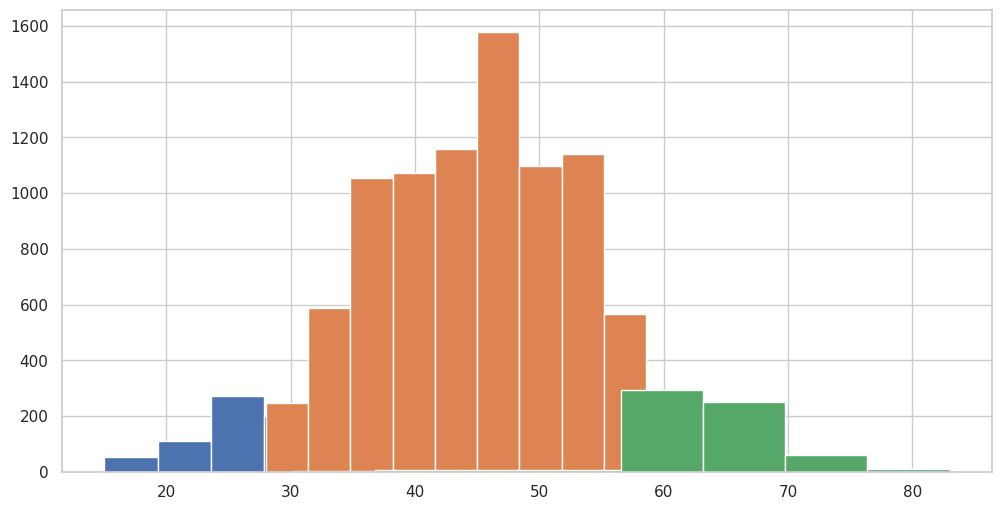

In [ ]:
ab_test.query("experiment_group == 'control'").groupby("district").delivery_time.hist()


district
Central     Axes(0.125,0.11;0.775x0.77)
Purlieus    Axes(0.125,0.11;0.775x0.77)
Suburb      Axes(0.125,0.11;0.775x0.77)
Name: delivery_time, dtype: object

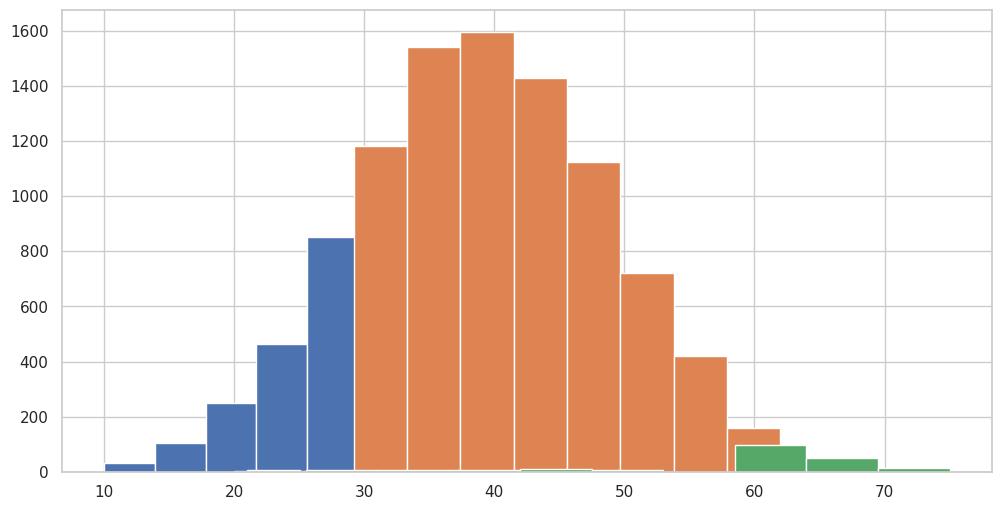

In [ ]:
ab_test.query("experiment_group == 'test'").groupby("district").delivery_time.hist()

district
Central     [[Axes(0.125,0.11;0.775x0.77)]]
Purlieus    [[Axes(0.125,0.11;0.775x0.77)]]
Suburb      [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

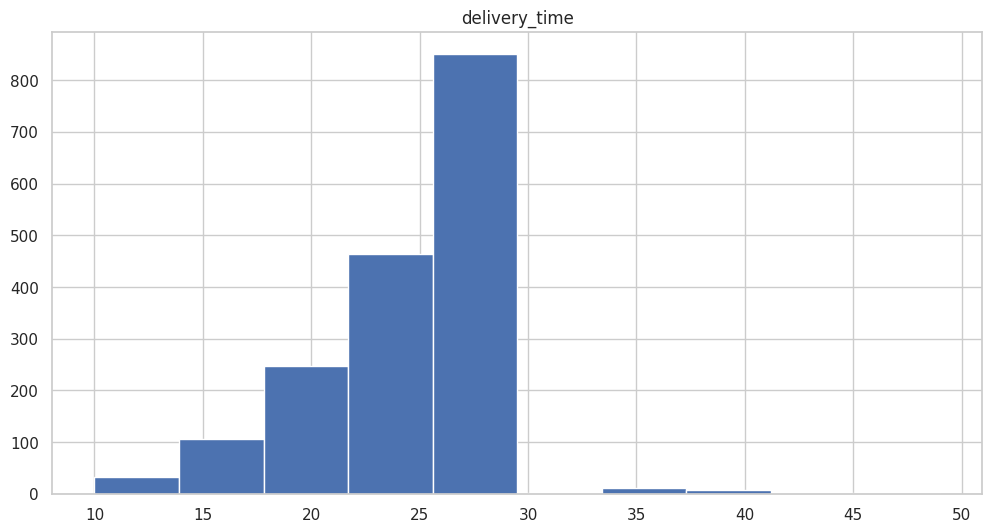

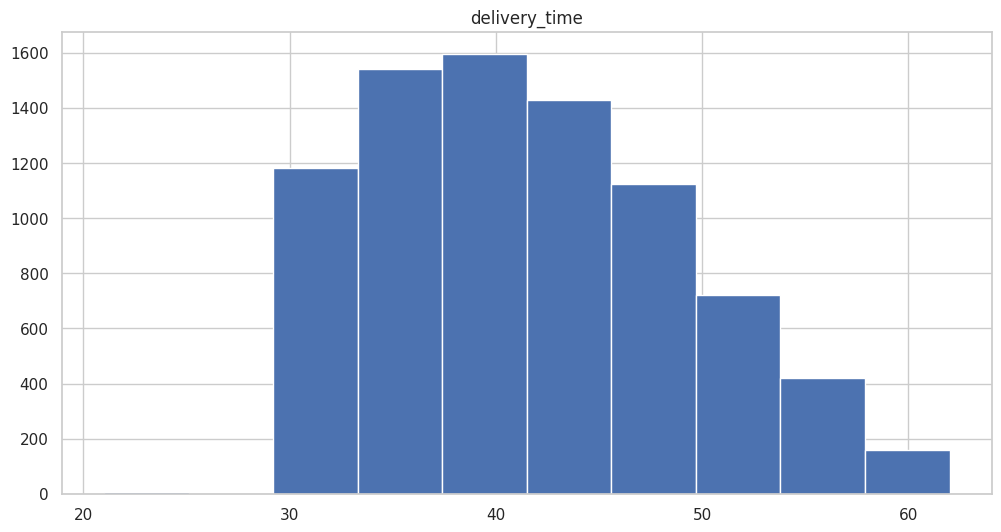

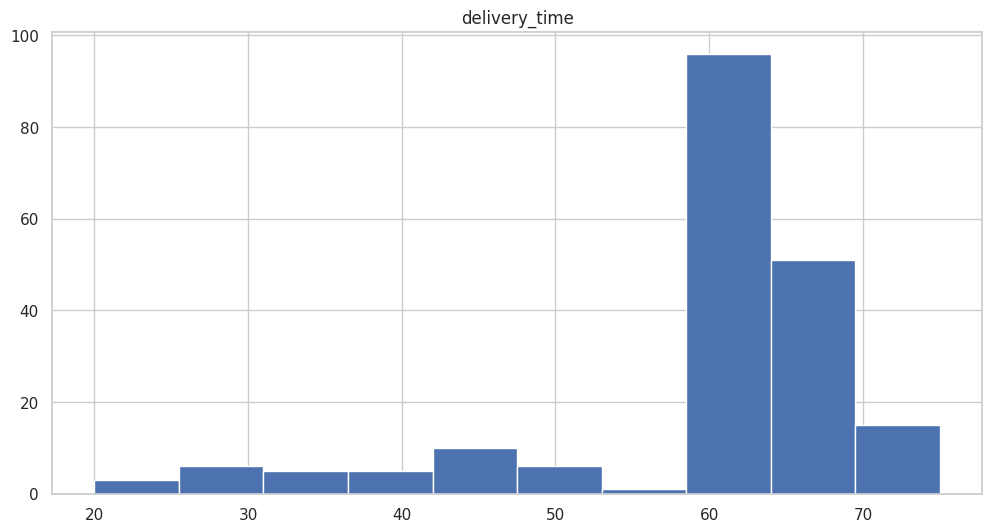

In [ ]:
ab_test.query("experiment_group == 'test'").groupby("district").hist("delivery_time")

<Axes: xlabel='delivery_time', ylabel='Count'>

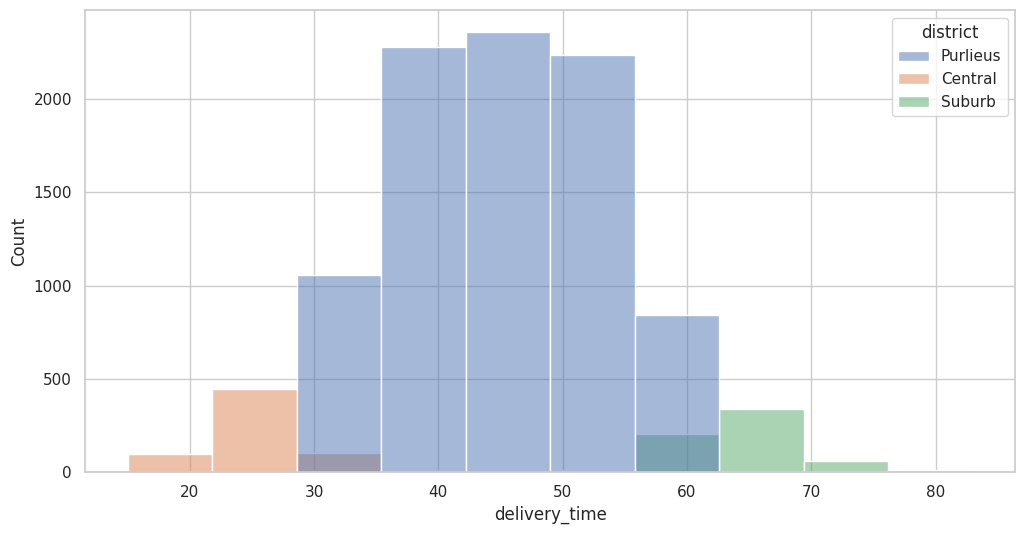

In [ ]:
sns.histplot(data = ab_test.query("experiment_group == 'control'"), x ='delivery_time', hue = 'district', bins = 10 )

<Axes: xlabel='delivery_time', ylabel='Count'>

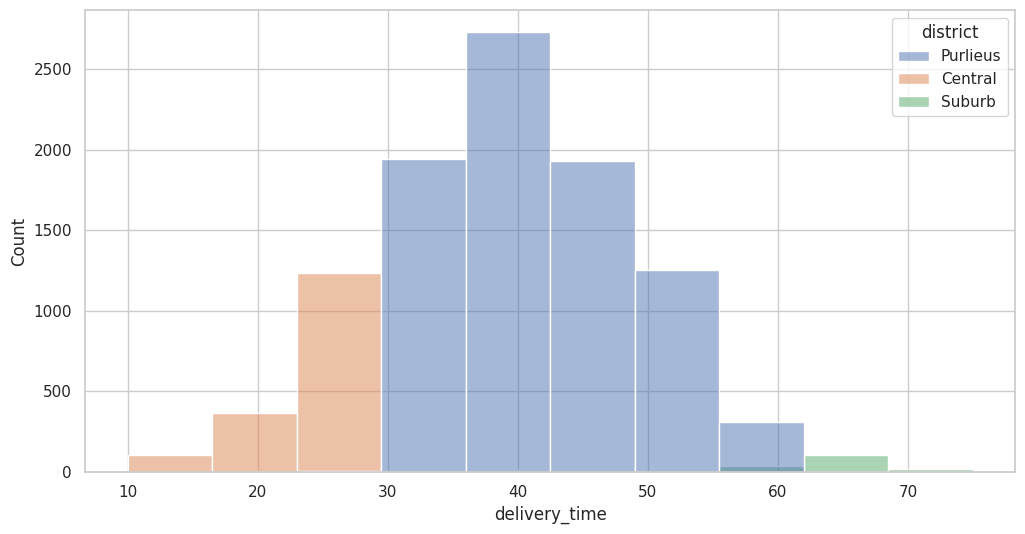

In [ ]:
sns.histplot(data = ab_test.query("experiment_group == 'test'"), x ='delivery_time', hue = 'district', bins = 10 )

##3) На сколько по модулю отличается колво наблюдений в тесте и контроле?


In [ ]:
ab_test.groupby("experiment_group").agg({'district':"count"})

,district
experiment_group,
control,10092
test,10104


In [ ]:
ab_test.groupby("experiment_group").size()

experiment_group
control    10092
test       10104
dtype: int64

##4) Посчитаем ско, проверим на нормальность


In [ ]:
ab_test.groupby("experiment_group").delivery_time.std()

experiment_group
control    9.990017
test       9.883308
Name: delivery_time, dtype: float64

##тест Шапиро: (точен на выборках < 50 эл-тов, если в выборке более 5000 эл-в его резы уже вовсе не надежны)

In [ ]:
pg.normality(data = ab_test, dv = "delivery_time", group = "experiment_group")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
experiment_group,,,
control,0.998722,3.223325e-07,False
test,0.998628,1.172024e-07,False


##Альтернативный тест (normal-тест)

In [ ]:
pg.normality(data = ab_test, dv = "delivery_time",  group = "experiment_group", method = 'normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


##Вариант с сэмплированием
(не очень надежен, но логика такая: если сама выборка распред нормально и "проблема" с большом ее объеме - потому отвергается Н0(тк тест слишком чувствит), то мы возьмем случайно часть наблюдений и проверим нормальность этой части)

In [ ]:
st.shapiro(ab_test.query("experiment_group == 'control'").delivery_time.sample(1000, random_state = 17))

ShapiroResult(statistic=0.9974724054336548, pvalue=0.12408281117677689)

<Axes: ylabel='Count'>

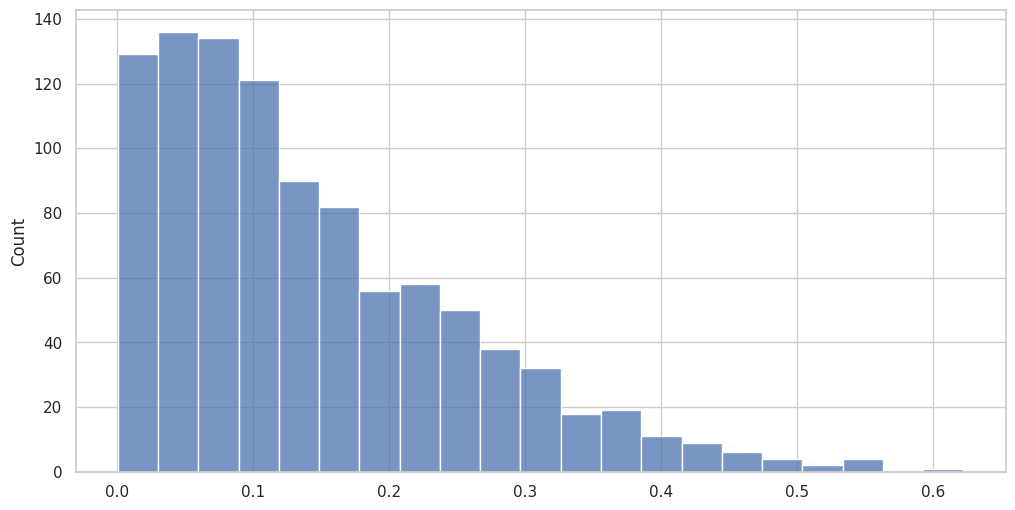

In [ ]:
pvals = []
for _ in range(1000):
    res = st.shapiro(ab_test.query("experiment_group == 'control'").delivery_time.sample(1000))
    pvals.append(res.pvalue)
sns.histplot(x = pvals)

In [ ]:
np.sum(np.array(pvals) < 0.05)/ len(pvals)

0.221

##QQPlot

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

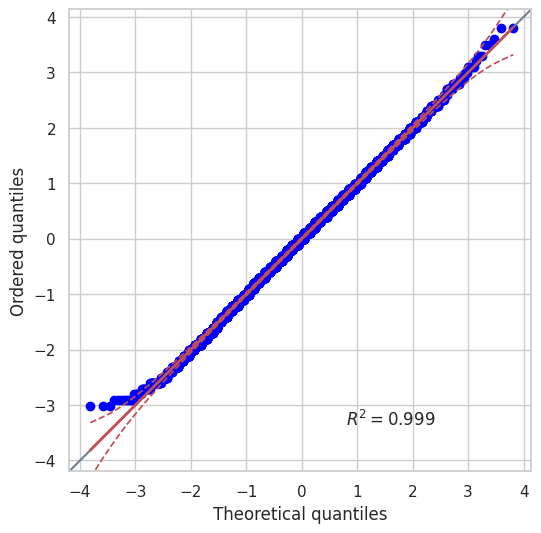

In [ ]:
pg.qqplot(ab_test.query("experiment_group == 'control'").delivery_time)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

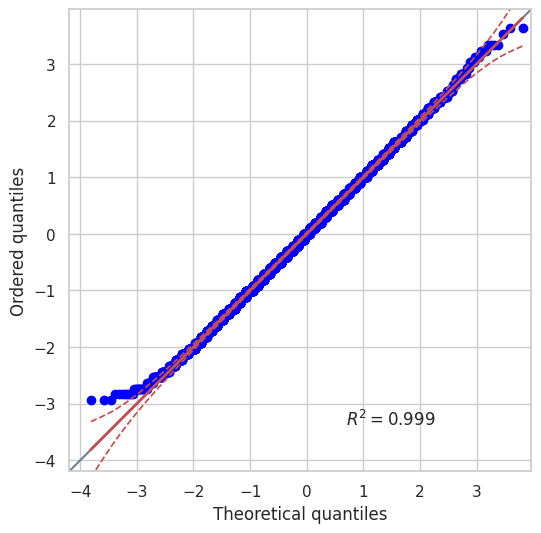

In [ ]:
pg.qqplot(ab_test.query("experiment_group == 'test'").delivery_time)

Видим что отклонения от нормальности и в контроле и в тесте небольшие, но в основном, ориентируясь на альтернативный normal-тест, можем сказать, что в контроле нормальное распределение, в тесте  - нет.

Однако как проверять гипотезы, если в тесте не нормальное распределение?

Все же, если мы посмотрим на саму форму распределения (тестовой группы), увидим, что оно не настолько уж сильно отличается от нормального, так что не будем об этом беспокоиться на таком большом размере выборки!

##5) Итак сравним средние в тесте и в контроле

Cравним рез-ты scipy pingouin (пока используем двустороннюю гипотезу, далее рассмотрим одностороннюю)

In [ ]:
st.ttest_ind(a = ab_test.query("experiment_group == 'test'").delivery_time, \
             b = ab_test.query("experiment_group == 'control'").delivery_time)

TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)

In [ ]:
pg.ttest(x = ab_test.query("experiment_group == 'test'").delivery_time, \
             y = ab_test.query("experiment_group == 'control'").delivery_time)

/usr/local/lib/python3.10/dist-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


Проверим через критерий Манна-Уитни

In [ ]:
st.mannwhitneyu(x = ab_test.query("experiment_group == 'test'").delivery_time, \
             y = ab_test.query("experiment_group == 'control'").delivery_time)

MannwhitneyuResult(statistic=33985060.0, pvalue=0.0)

Модификации к классическому t-тесту

t-тест Юрина (не учитываем выбросы - аномально низкие и высокие значения)

In [ ]:
st.ttest_ind(a = ab_test.query("experiment_group == 'test'").delivery_time, \
             b = ab_test.query("experiment_group == 'control'").delivery_time, trim = 0.2)

TtestResult(statistic=-42.16055367343425, pvalue=0.0, df=12118.0)

Перестановочный тест (случайным образом перемешиваем группы - и измеряем статистику, повторяем так много раз, строим распределение, считаем pvalue = доля статистики из перестановок/ все измерения. )

In [ ]:
st.ttest_ind(a = ab_test.query("experiment_group == 'test'").delivery_time, \
             b = ab_test.query("experiment_group == 'control'").delivery_time, permutations = 1000)

TtestResult(statistic=-43.03582663183714, pvalue=0.000999000999000999, df=nan)

На сколько изменилось среднее время доставки в test по сравнению с control ?

In [ ]:
mean_test = ab_test.query("experiment_group == 'test'").delivery_time.mean()
mean_control = ab_test.query("experiment_group == 'control'").delivery_time.mean()
(1 - mean_test/mean_control)

0.1335465312166081

Мы проверяли двустороннюю гипотезы, теперь проверим одностороннюю:

In [ ]:
# Двусторонний тест (по умолчанию)
result_two_sided = st.ttest_ind(
    a = ab_test.query("experiment_group == 'test'").delivery_time,
    b = ab_test.query("experiment_group == 'control'").delivery_time
)

# Односторонний тест: проверка гипотезы, что среднее значение группы 'test' меньше среднего значения группы 'control'
result_one_sided_less = st.ttest_ind(
    a = ab_test.query("experiment_group == 'test'").delivery_time,
    b = ab_test.query("experiment_group == 'control'").delivery_time,
    alternative='less'
)

# Односторонний тест: проверка гипотезы, что среднее значение группы 'test' больше среднего значения группы 'control'
result_one_sided_greater = st.ttest_ind(
    a = ab_test.query("experiment_group == 'test'").delivery_time,
    b = ab_test.query("experiment_group == 'control'").delivery_time,
    alternative='greater'
)

# Вывод результатов
print("Двусторонний тест:", result_two_sided)
print("Односторонний тест (less):", result_one_sided_less)
print("Односторонний тест (greater):", result_one_sided_greater)


Двусторонний тест: TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)
Односторонний тест (less): TtestResult(statistic=-43.03582663183714, pvalue=0.0, df=20194.0)
Односторонний тест (greater): TtestResult(statistic=-43.03582663183714, pvalue=1.0, df=20194.0)


##6) Итак, делаем вывод:

Мы принимаем нововведения!